In [1]:
from numpy import *
import matplotlib.pyplot as plt
%matplotlib inline
import re
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.integrate import quad

In [2]:
class color:
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

In [3]:
#Define motor class
class Motor:
    def __init__(self, name):
            file_name = name + '.txt'
            words = []

            #read the text file and split by word
            with open(file_name, 'r') as f:
                for line in f:
                    for word in line.split():
                        words.append(word)

            #search word array for the keyword total get index of value 2 words later
            motorTotalWeightIndex = words.index("total") + 2

            #search word array for keyword propellant get index of value 2 words later
            motorPropWeightIndex = words.index("propellant") + 2

            mTWSTR = words[motorTotalWeightIndex]
            mPWSTR = words[motorPropWeightIndex]

            #extract the value as an int from the word entry
            motorTotalWeight = int(re.search(r'\d+', mTWSTR).group())
            motorPropellantWeight = int(re.search(r'\d+', mPWSTR).group())
            
            self.name = name
            self.wetMass = motorTotalWeight
            self.propMass = motorPropellantWeight
            self.dryMass = motorTotalWeight - motorPropellantWeight
            
            #search the data for the thrust cure, interp 1D and add 0 line to -time and after MECO
            lines = [] #Declare an empty list named "lines"
            i = 0
            with open (file_name, 'rt') as in_file:  #Open file lorem.txt for reading of text data.
                for line in in_file: #For each line of text store in a string variable named "line", and
                    dataPoint = map(float, re.findall(r'\d+', line))
                    dataPointint = fromiter(dataPoint, dtype=float)
                    i = i + 1
                    if (len(dataPointint) > 2) & (i>4):
                        dataPointTogetherTime = dataPointint[0] + 0.01*dataPointint[1]

                        dataPointTogetherThrust = dataPointint[2] + 0.01*dataPointint[3]

                        #print(dataPointint)


                        lines.append([dataPointTogetherTime, dataPointTogetherThrust])  #add that line to our list of lines.

            linescon = concatenate(lines, axis=0 )

            times = linescon[0:][::2]
            
            self.timepoints = times
            
            thrust = linescon[1:][::2]
            
            self.thrustpoints = thrust
            
            testtime = linspace(0,5,100)

            thrustInterp = interp1d(times,thrust, fill_value = (0,0), bounds_error=False)
            
            self.ThrustCurve = thrustInterp
            
            #Total Impulse Calc
            totalImpulse = quad(self.ThrustCurve, min(self.timepoints), max(self.timepoints))
            
            self.totalI = totalImpulse[0]
            
            self.ISP = self.totalI / (self.propMass*(10**-3) * 9.8) #Ns/N
            
    def printspecs(self): #function to print motor specs
        print('Motor:', color.BOLD , self , color.END)
        print('Wet Mass:', self.wetMass, 'g')
        print('Prop Mass:', self.propMass, 'g')
        print('Dry Mass:', self.dryMass, 'g \n')
    def plotThrustCurve(self): #function to plot thrustcurve
        testtime = linspace(0,max(self.timepoints),100)
        plt.plot(self.timepoints,self.thrustpoints, '.', color='red', label = self.name + ' data points')
        plt.plot(testtime,self.ThrustCurve(testtime), label= self.name + ' Interp Thrust Curve')
        plt.legend()
        plt.grid()

    def __str__(self):
            return self.name #return name when print is called

In [4]:
#Motor Library
#Ensure that this name is the same as the motor spec .txt file saved in same directory
#Files must be in the CompuRoc (.txt) format

J420 = Motor('AeroTech_J420')
J315 = Motor('AeroTech_J315')
J275 = Motor('AeroTech_J275')
J460 = Motor('AeroTech_J460')
J800 = Motor('AeroTech_J800')
K185 = Motor('AeroTech_K185')
K535 = Motor('AeroTech_K535')

/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


In [5]:
#Define parachute class
class Parachute:
    def __init__(self, diameter, mass, CD, name):
            self.d = diameter
            self.area = pi*(diameter/2)**2
            self.m = mass
            self.Cd = CD
            self.name = name
    def printspecs(self):
        print('Parachute:', color.BOLD , self , color.END)
        print('     Diameter:', self.d, 'in')
        print('     Area:', round(self.area,2), 'in2')
        print('     Mass:', self.m, 'g')
        print('     CD:', self.Cd)
    def __str__(self):
            return self.name

In [6]:
#Parachute Library

#Drogue Parachute Options
FruityChute15 = Parachute(15,43,1.5, "FruityChute15")
FruityChute18 = Parachute(18,60,1.5, "FruityChute18")

#Main Parachute Options
FruityChute48Iris = Parachute(48,212.62,2.2, "FruityChute48Iris")
FruityChute60Iris = Parachute(60,309,2.2, "FruityChute60Iris")

In [7]:
drogueChuteSelected = FruityChute15
mainChuteSelected = FruityChute60Iris
motorSelected = J420

In [15]:
#Pre-Build Rocket Mass and CG Approximations

rocketOD = 3.05
rocketID = 3
couplerID = 2.87
motorTubeOD = 1.6
motorTubeID = 1.52
blueTubeCouplerLinearDensity75mm = 78.4/8 #g/in
PLA3DprintsDenisty = 20.3 #g/in3
avionicsSledApproximateArea = 2*(3/8)
avionicsSledApproximateLinearDensity = avionicsSledApproximateArea*PLA3DprintsDenisty

#Airframe
motorSection = 22
lowerADASOverlap = 6
ADASRing = 1
upperADASOverlap = 6
parachuteSpace = 16
RecoveryChargeSpace = 1
lowerRecoveryOverlap = 3
recoveryRing = 1
upperRecoveryOverlap = 3
payloadChargeSpace = 1
payloadSectionLength = 15

rocketBody = motorSection + lowerADASOverlap + ADASRing + upperADASOverlap + parachuteSpace \
    + RecoveryChargeSpace + lowerRecoveryOverlap + recoveryRing + upperRecoveryOverlap + payloadChargeSpace\
    + payloadSectionLength

CFAirframeLinearDensity = 1088/72 #g/in #MEASURE THIS
airframeMass = rocketBody*CFAirframeLinearDensity

airframeComponent = [airframeMass,(rocketBody/2)]
#each component will include the mass and position from the tail of the rocket for CG calculations

#Motor tube
motorTube = 22
fiberglassMotorTubeLinearDensity38mm = 273/48 #g/in
motorTubeMass = motorTube*fiberglassMotorTubeLinearDensity38mm
motorTubeComponent = [motorTubeMass,(motorTube/2)]

#Centering rings
CRArea = pi*((rocketID/2)**2 - (motorTubeOD/2)**2)
#Particle Board
CRthickness = 3/8
PBDensity = 12.3 #g/in3
CRMass = CRArea*CRthickness*PBDensity
#Aluminum
'''
CRthickness = 1/8
AlDensity = 45
CRMass = CRArea*CRthickness*AlDensity
'''
#There will be 3 fixed CRs, and one clamping centered about the motor tube
CRComponent = [CRMass,(motorTube/2)]

#ADAS
ADASLength = lowerADASOverlap + ADASRing + upperADASOverlap
ADASCouplerMass = (ADASLength)*blueTubeCouplerLinearDensity75mm
ADASMotorMass = 340
ADASSledMass = (ADASLength)*avionicsSledApproximateLinearDensity
ADASBulkheads = 2*PBDensity*pi*(rocketID/2)**2
ADASBattery = 169
ADASAvionics = 100 #? measure?
ADASMass = ADASCouplerMass + ADASMotorMass + ADASSledMass +ADASBulkheads + ADASBattery + ADASAvionics
ADASComponent = [ADASMass,motorTube + (ADASLength/2)]


#Parachutes
drogueMass = drogueChuteSelected.m
mainMass = mainChuteSelected.m
chuteReleaseMass = 17.5
parachuteMass = drogueMass + mainMass + chuteReleaseMass*2
parachutesComponent = [parachuteMass, motorTube + ADASLength + (parachuteSpace/2)]

#Recovery
recoveryLength = lowerRecoveryOverlap + recoveryRing + upperRecoveryOverlap
recoverySledMass = (recoveryLength)*avionicsSledApproximateLinearDensity
recoveryBulkheads = 2*PBDensity*pi*(rocketID/2)**2
recovery9vmass = 40
recoveryAvionics = 10.7 + 10
recoveryMass = recoverySledMass + recoveryBulkheads + recovery9vmass*2 + recoveryAvionics
recoveryComponent = [recoveryMass, motorTube + ADASLength + parachuteSpace + RecoveryChargeSpace + (recoveryLength/2)]

#Payload
payloadMassApprox = 1542*(3/5)**3 #scaled as volume (e.g. density)
payloadComponent = [payloadMassApprox, motorTube + ADASLength + parachuteSpace + RecoveryChargeSpace + recoveryLength + payloadChargeSpace + (payloadSectionLength/2)]
print('payload sim mass', payloadMassApprox, 'g')

#Nose Cone
noseCone = 363
GPS = 20
ABS = (6)*avionicsSledApproximateLinearDensity
GPS_Bat = 68
noseConeMass = noseCone + GPS + ABS + GPS_Bat
noseConeLength = 13.13
noseConeComponent = [noseConeMass,rocketBody-(noseConeLength/2)]

#Rocket Without Fins
rocketSegments = []
rocketSegments.extend(airframeComponent)
rocketSegments.extend(motorTubeComponent)
rocketSegments.extend(CRComponent)
rocketSegments.extend(ADASComponent)
rocketSegments.extend(parachutesComponent)
rocketSegments.extend(recoveryComponent)
rocketSegments.extend(payloadComponent)
rocketSegments.extend(noseConeComponent)

segmentMasses = array(rocketSegments[0:][::2])
segmentCGs = array(rocketSegments[1:][::2])

CG_noFins = (sum(segmentMasses * segmentCGs))/(sum(segmentMasses)) #in
rocketMass_noFins = sum(segmentMasses) #g


payload sim mass 333.07199999999995 g


In [16]:
#adding Ballast 10% max
Max_Ballast = 0.1 * rocketMass_noFins
Planned_Ballast = 0.075 * rocketMass_noFins #room to adjust
print('Planned Ballast:', Planned_Ballast)

#Move Ballast to nosecone
rocketMass_noFins_withBallast = rocketMass_noFins + Planned_Ballast
Ballast_Location = motorTube + ADASLength + parachuteSpace + RecoveryChargeSpace + recoveryLength + payloadChargeSpace + payloadSectionLength
CG_noFins_withBallast = (rocketMass_noFins*CG_noFins + Ballast_Location*Planned_Ballast)/(rocketMass_noFins_withBallast)

print('Rocket Mass (No Fins With 50% Max Ballast):', rocketMass_noFins_withBallast, 'g')
print('Rocket CG (No Fins With 50% Max Ballast):', CG_noFins_withBallast, 'in')

Planned Ballast: 302.5188374872772
Rocket Mass (No Fins With 50% Max Ballast): 4336.10333731764 g
Rocket CG (No Fins With 50% Max Ballast): 45.15564532727694 in


Rocket Static Stbility Marigin: 2.165530058480017

Fin Shape
Fin Span: 3.375


(-6.9, 12.9, -0.16875, 3.54375)

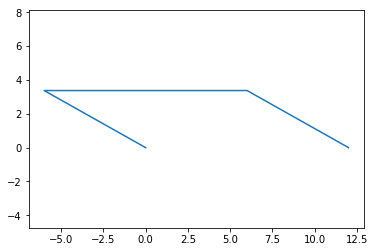

In [17]:
#Fin Optimization
'''
 ______________     _
 \             \     |
  \             \    | Fin Span
   \_____________\  _|
         RC
Fin Shape:45deg parallelogram
RC:Root Chord
'''
RC = 12

#finding center of areas
#Rocket Body
bodyArea = rocketOD * rocketBody
centerOfRocketBodyArea = rocketBody/2

noseconeArea = (rocketOD*noseConeLength)/2
noseconeCenterOfArea = rocketBody + (noseConeLength/2)

finArea = 12*(3+3/8) #????
finCenterOfArea = RC*(1/4) #/2 if symmetric, /4 for parallelogram design

CP = (bodyArea*centerOfRocketBodyArea + noseconeArea*noseconeCenterOfArea + 2*finArea*finCenterOfArea) / (bodyArea + noseconeArea + 2*finArea)

targetStabilityMarigin = 2.25 #2 minimum, give ourselves room

surfaceDensityOfFinMaterial = 14.7484/2 * 0.25 #14.7484 * 0.25 #0.25 in thick ABS #g/in2 #1/4 thick fiberglass 1162.1/(12**2) 

finMass = surfaceDensityOfFinMaterial*finArea

CG = (CG_noFins_withBallast*rocketMass_noFins_withBallast + (1+RC/2)*4*finMass + 7*motorSelected.wetMass)/(rocketMass_noFins_withBallast + 4*finMass + motorSelected.wetMass)
#the 7 is from half the motor length

rocketDryMass = rocketMass_noFins_withBallast + 4*finMass
rocketWetMass = rocketDryMass + motorSelected.wetMass
dryCG = (CG_noFins_withBallast*rocketMass_noFins_withBallast + (1+RC/2)*4*finMass)/(rocketMass_noFins_withBallast + 4*finMass)




stabilityMarigin = (CG-CP)/rocketOD

print('Rocket Static Stbility Marigin:', stabilityMarigin)

#shape simple srectangle and square
# A = 3/2 * 6 * len
# A/6 * 2/3 = len
# len = A/9
finSpan = finArea/12
print('\nFin Shape')
print('Fin Span:',finSpan)

plt.plot([0,-RC/2,RC/2,RC],[0,finSpan,finSpan,0])
plt.axis('equal')

Rocket Dry Mass: 4634.76 g
Rocket Dry CG: 42.7 in
Rocket Wet Mass: 5284.76 g
Rocket Wet CG: 38.31 in
Rocket CP: 31.7 in
Rocket Static Stbility Marigin: 2.165530058480017


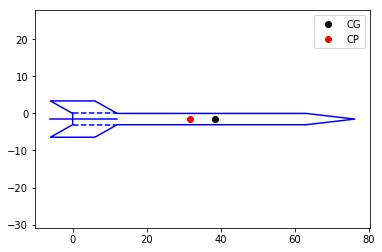

In [18]:
#For fun plot rocket shape

plt.plot([0,-RC/2,RC/2,RC,rocketBody-RC,rocketBody-RC+noseConeLength,rocketBody-RC,RC,RC/2,-RC/2,0,0],
         [0,finSpan,finSpan,0,0,-rocketOD/2,-rocketOD,-rocketOD,-rocketOD-finSpan,-rocketOD-finSpan,-rocketOD,0], color='blue')
plt.plot([0,RC],[0,0],'--',color='blue')
plt.plot([0,RC],[-rocketOD,-rocketOD],'--',color='blue')
plt.plot([-RC/2,RC],[-rocketOD/2,-rocketOD/2],color='blue')
plt.plot(CG,-rocketOD/2,'o',color='black', label='CG')
plt.plot(CP,-rocketOD/2,'o',color='red', label='CP')
plt.axis('equal')
plt.legend()

print('Rocket Dry Mass:', round(rocketDryMass,2) , 'g')
print('Rocket Dry CG:', round(dryCG,2) ,'in')
print('Rocket Wet Mass:', round(rocketWetMass,2) , 'g')
print('Rocket Wet CG:', round(CG,2) , 'in')
print('Rocket CP:', round(CP,2) ,'in')
print('Rocket Static Stbility Marigin:', stabilityMarigin)

In [19]:
#define the rocket class
class Rocket:
    def __init__(self, name, diameter, dryMass, CP, dryCG, Cd):
        self.name = name
        self.diameter = diameter
        self.CA = pi*(diameter/2)**2
        self.dryMass = dryMass
        self.CP = CP
        self.dryCG = dryCG
        self.Cd = Cd
        self.dryStabilityMarigin = (self.dryCG - self.CP)/self.diameter
        
    def printspecs(self): #function to print motor specs
        print('Rocket:', color.BOLD , self , color.END)
        print('Diameter:', round(self.diameter,2), 'in')
        print('Cross-Sectional Area', round(self.CA,2), 'in2')
        print('Dry Mass:', round(self.dryMass,2), 'g')
        print('CP:', round(self.CP,2), 'in')
        print('Dry CG:', round(self.dryCG,2), 'in')
        print('Cd:', round(self.Cd,2))
        print('Dry Stanility Marigin:', round(self.dryStabilityMarigin,2))
        

    def __str__(self):
            return self.name #return name when print is called

In [22]:
dryCG

42.69696744257202

In [23]:

#Define Rocket Library

Subscale2k18prediction = Rocket('Endavour',3,4634.75,31.7,42.7,0.44)
#Subscale2k18prediction = Rocket('Endavour',3,rocketDryMass,CP,dryCG,0.44)
#FullScale2k17 = Rocket('')
Subscale2k17 = Rocket("She'll Be Right",3,4.5e3,8*12-74.5,8*12-63.8,0.44)
Fullscale2k17 = Rocket("Effective - 1",3,5.14e3,94.75-74.4,94.75-59.8,0.44)

 ROCKET SELECTED: 
Rocket:  Endavour 
Diameter: 3 in
Cross-Sectional Area 7.07 in2
Dry Mass: 4634.76 g
CP: 31.7 in
Dry CG: 42.7 in
Cd: 0.44
Dry Stanility Marigin: 3.67


 PARACHUTES SELECTED: 
  DROGUE: 
Parachute:  FruityChute15 
     Diameter: 15 in
     Area: 176.71 in2
     Mass: 43 g
     CD: 1.5

   MAIN: 
Parachute:  FruityChute60Iris 
     Diameter: 60 in
     Area: 2827.43 in2
     Mass: 309 g
     CD: 2.2


 MOTOR SELECTED: 
Motor:  AeroTech_J420 
Wet Mass: 650 g
Prop Mass: 376 g
Dry Mass: 274 g 



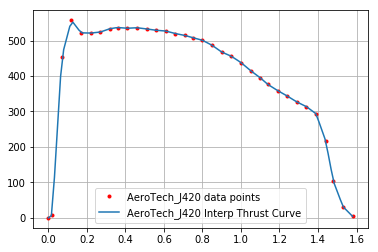

In [21]:
#Rocket Selection
print(color.UNDERLINE, 'ROCKET SELECTED:', color.END)
RocketSelected = Subscale2k18prediction
RocketSelected.printspecs()

print('\n')

#Parachute Selection
drogueChuteSelected = FruityChute15
mainChuteSelected = FruityChute60Iris

print(color.UNDERLINE, 'PARACHUTES SELECTED:', color.END)

print( color.BOLD ,' DROGUE:',color.END)
drogueChuteSelected.printspecs()

print('\n ', color.BOLD, 'MAIN:', color.END)
mainChuteSelected.printspecs()

print('\n')

#Motor Selection
print(color.UNDERLINE, 'MOTOR SELECTED:', color.END)
motorSelected = J420

motorSelected.printspecs()
motorSelected.plotThrustCurve()



In [22]:
#Initial Conditions

h = 0 #initial height
v0 = 0 #initial velocity
m0 = RocketSelected.dryMass + motorSelected.wetMass
mMECO = RocketSelected.dryMass + motorSelected.dryMass

windSpeedmph = 0#mph
windSpeedms = windSpeedmph*0.44704 #m/s

launchRailLengthft = 8 #ft
launchRailLengthm = launchRailLengthft*0.3048 #m

mainChuteReleaseAlt = 800 #ft
launchRailLengthm = mainChuteReleaseAlt*0.3048 #m

#Static Stability Marigin for Selected Rocket and Motor

###USER INPUT REQUIRED###
motorLength = 18 #in (This will vary with motor selection and not included in the thrust curve txt data....)

CG0 = (RocketSelected.dryMass*RocketSelected.dryCG + (motorLength/2)*motorSelected.wetMass)/(RocketSelected.dryMass + motorSelected.wetMass)
CP = RocketSelected.CP
StaticStabilityMariginSelected = (CG0 - CP)/RocketSelected.diameter

print(color.BOLD, "SELECTED CONFIGURATION", color.END)
print("Gross Lift Off Weight:",round(m0*(10**-3),2),'kg')
print("CP:",round(CP,2),'in')
print("CG:",round(CG,2),'in')
print("Static Stability Marigin:", round(StaticStabilityMariginSelected,2))
thrustToWeightRatio = max(motorSelected.thrustpoints) / (m0*(10**-3)*9.8)
print("Thrust To Weight Ratio:", round(thrustToWeightRatio,2))

 SELECTED CONFIGURATION 
Gross Lift Off Weight: 5.28 kg
CP: 31.7 in
CG: 38.31 in
Static Stability Marigin: 2.28
Thrust To Weight Ratio: 10.76


In [23]:
#Thrust Equation
#F = g0 * ISP * (dm/dt)
#F(t)/(g0 * ISP) = dm/dt

#Analytical Solution to mass function
#m(t) = integral((t)/(g0 * ISP))dt + m0


In [24]:
#integration method

#phases, t0 to MECO, coast, then parachute descents

#weather cocking factor based on stability marigin/fin area?

In [25]:
RocketSelected.dryMass + motorSelected.dryMass

4908.75843731764

In [26]:
5.15*9.8

50.470000000000006